In [1]:
%%capture
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data =pd.read_csv('bank/bank.csv',sep=';')
col_cat = ['job','marital','education','default','housing','loan','contact','month','poutcome']
col_num = ['age','balance','day','duration','campaign','pdays','previous']
data_categorical = pd.get_dummies(data[col_cat])
data_numerical = data[col_num]
data_set = pd.concat([data_categorical,data_numerical],axis = 1)

from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
X =data_set.values
y = data['y'].copy()
y = y.ravel()
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1)
feat_selector.fit(X, y)
feat_selector.support_
feat_selector.ranking_
X_filtered = feat_selector.transform(X)

x_feat = data_set.copy()
drop_col = x_feat.columns[feat_selector.ranking_ > 1]
x_feat.drop(drop_col,axis = 1, inplace=True)


y[y == 'no'] = -1
y[y == 'yes'] = 1
y=y.astype('float')

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_feat, y, test_size=0.30, random_state=0)


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)


In [2]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(x_train, y_train)
predicted_label = knn.predict(x_test)

 Classification Report
             precision    recall  f1-score   support

       -1.0       0.91      0.95      0.93      1190
        1.0       0.50      0.37      0.43       167

avg / total       0.86      0.88      0.87      1357

Confusion Metrics: 
 [[1129   61]
 [ 105   62]]


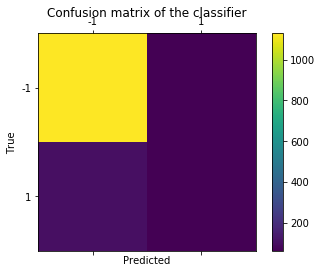

Test Accuracy of random forest 87.77%


In [3]:
from sklearn.metrics import classification_report

report = classification_report(y_test, predicted_label)
print(f' Classification Report\n{report}')

from sklearn import metrics
labels=[-1,1]
cm = metrics.confusion_matrix(y_test, predicted_label, labels)
print(f'Confusion Metrics: \n {cm}')
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

score=knn.score(x_test,y_test)*100
print(f'Test Accuracy of knn is {round(score,2)}%')

In [4]:
# Tunning hyper parameter k


# creating odd list of K for KNN
neighbors = list(range(1,50,2))

# subsetting just the odd ones
#neighbors = filter(lambda x: x % 2 != 0, myList)

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
from sklearn import model_selection

kfold = model_selection.KFold(n_splits=10, random_state=30) # random state =seed
for k in neighbors:
    knn_hp = KNeighborsClassifier(n_neighbors=k)
    scores = model_selection.cross_val_score(knn_hp, x_train, y_train, cv= kfold, scoring='accuracy')
    cv_scores.append(scores.mean())


The optimal number of neighbors is 9


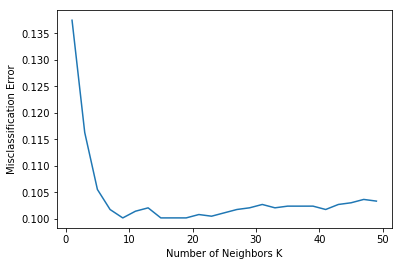

In [15]:
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print(f"The optimal number of neighbors is {optimal_k}")

# plot misclassification error vs k
plt.plot(neighbors, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()




 Classification Report
             precision    recall  f1-score   support

       -1.0       0.92      0.97      0.94      1190
        1.0       0.63      0.38      0.47       167

avg / total       0.88      0.90      0.88      1357

Confusion Metrics: 
 [[1153   37]
 [ 104   63]]


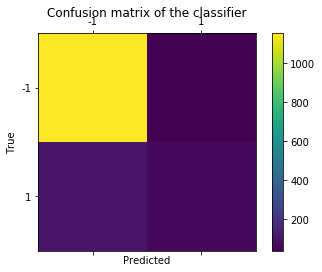

Test Accuracy of random forest 89.61%


In [28]:
# Running knn with n = 9

# from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 9)
knn.fit(x_train, y_train)
predicted_label = knn.predict(x_test)

# from sklearn.metrics import classification_report

report = classification_report(y_test, predicted_label)
print(f' Classification Report\n{report}')

# from sklearn import metrics

labels=[-1,1]
cm = metrics.confusion_matrix(y_test, predicted_label, labels)
print(f'Confusion Metrics: \n {cm}')
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

score=knn.score(x_test,y_test)*100
print(f'Test Accuracy of random forest {round(score,2)}%')